In [76]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
#"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv"
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
# plt.style.use('fivethirtyeight')

In [77]:
# salmon_data = pd.read_csv(r"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv")
# salmon_data.head()
# salmon_copy = salmon_data # Create a copy for us to work with 
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
#     print(salmon_copy)
    king_data = salmon_copy.filter(["date","king"], axis=1)
    print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [84]:
    king_all_copy, king_data= load_data('/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv')
    print(king_all_copy)

            date  king
0     1938-05-01   201
1     1938-05-02   227
2     1938-05-03    78
3     1938-05-04    37
4     1938-05-05    29
...          ...   ...
24729 2021-04-28  2433
24730 2021-04-29  4782
24731 2021-04-30  4641
24732 2021-05-01  2087
24733 2021-05-02  2517

[24734 rows x 2 columns]
            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [117]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)
    
    # Todo: Normalize data with MinMaxScalar
    king_training[king_training["king"] < 0] = 0 #get rid of negatives
    king_test[king_test["king"] < 0] = 0 #get rid of negatives
   # sc = MinMaxScaler(feature_range=(0,1))\
#     try_this = king_training["king"].reshape(-1, 1)
    #king_train_norm = sc.fit_transform(king_training)
    king_train_norm = (king_training["king"] - np.min(king_training["king"])) / (np.max(king_training["king"]) - np.min(king_training["king"]))
    # removed this because we do not want to normalize the test set
    king_test_norm = (king_test["king"] - np.min(king_test["king"])) / (np.max(king_test["king"]) - np.min(king_test["king"]))
    

    x_train = []
    y_train = []
    x_test = []
    y_test = []
    y_not_norm_test = []
    
    # Todo: Experiment with input size of input (ex. 30 days)
    
    for i in range(180,22544): # 30
        x_train.append(king_train_norm[i-180:i])
        y_train.append(king_train_norm[i])
    
    for i in range(180, 1824):
        x_test.append(king_test_norm[i-180:i])
        y_test.append(king_test_norm[i])
        
    for i in range(180, 1824):
#         x_test.append(king_test_norm[i-180:i])
        y_not_norm_test.append(king_test["king"][i])
        
    return x_train, y_train, x_test, y_test, king_test, king_training, y_not_norm_test

In [119]:
x_train, y_train, x_test, y_test, king_test, king_training, y_not_norm_test = create_train_test(king_all_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
# i = 3
print(x_train)
print(y_not_norm_test)
# new_xtrain = temp(king_training, x_train)
# print(king_training["king"][i])

# print(new_xtrain[i])


[[[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  ...
  [3.0657130e-03]
  [3.4063477e-03]
  [6.9163670e-03]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [1.4810207e-05]
  ...
  [3.4063477e-03]
  [6.9163670e-03]
  [7.9678912e-03]]

 [[0.0000000e+00]
  [1.4810207e-05]
  [0.0000000e+00]
  ...
  [6.9163670e-03]
  [7.9678912e-03]
  [7.0940894e-03]]

 ...

 [[5.1139645e-02]
  [4.4741634e-02]
  [3.3574741e-02]
  ...
  [1.4810207e-05]
  [1.4810207e-05]
  [5.9240829e-05]]

 [[4.4741634e-02]
  [3.3574741e-02]
  [5.1983826e-02]
  ...
  [1.4810207e-05]
  [5.9240829e-05]
  [0.0000000e+00]]

 [[3.3574741e-02]
  [5.1983826e-02]
  [4.7377855e-02]
  ...
  [5.9240829e-05]
  [0.0000000e+00]
  [0.0000000e+00]]]
[3042, 2756, 2374, 1813, 2474, 2186, 1959, 1857, 1713, 1884, 1648, 1398, 1571, 1432, 1549, 1187, 1137, 1385, 1212, 1149, 912, 1302, 1129, 1125, 1135, 888, 810, 1030, 1045, 798, 690, 647, 687, 510, 624, 723, 820, 892, 876, 1050, 920, 652, 867, 1659, 2093, 1983, 1998, 1524, 887, 1990, 4911, 6264, 34

In [111]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [136]:
def create_single_layer_rnn_model(x_train, y_train, x_test):
    '''
    create single layer rnn model trained on x_train and y_train
    and make predictions on the x_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # fit the RNN model
    history = model.fit(x_train, y_train, epochs=1000, batch_size=64)

    print("predicting")
    # Finalizing predictions
    #scaled_
    test_preds = model.predict(x_test)
    # we want unnormalized preds as Natural Numbers
#     test_preds = 
    

    return model, test_preds, history

In [8]:
def create_GRU_model(x_train, y_train, x_test, y_test):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dense(units=1))

    # Compiling the RNN
    regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(x_train,y_train,epochs=1500,batch_size=150)
    

    GRU_predicted_salmon_count = regressorGRU.predict(x_test)

    return regressorGRU, GRU_predicted_salmon_count

In [135]:
# sns.lineplot(
#     data=king_test,
#     x="date", y="king"
# )

In [ ]:
# model, test_preds = create_single_layer_rnn_model(x_train, y_train, x_test)

In [ ]:
#uncomment
#regressorGRU, GRU_predicted_num = create_GRU_model(x_train, y_train, x_test, y_test)

In [ ]:
plot_predictions(y_test, GRU_predicted_num)

In [ ]:
accuracy = accuracy_score(y_test, np.round(GRU_predicted_n3um.reshape(GRU_predicted_num.shape[0])))

In [ ]:
accuracy

In [ ]:
GRU_predicted_num

In [137]:
# test basic single layer RNN
model, test_preds, history = create_single_layer_rnn_model(x_train, y_train, x_test)

Epoch 1/1000
350/350 [==============================] - 7s 19ms/step - loss: 0.0017
Epoch 2/1000
350/350 [==============================] - 7s 20ms/step - loss: 3.6798e-04
Epoch 3/1000
350/350 [==============================] - 7s 20ms/step - loss: 3.2016e-04
Epoch 4/1000
350/350 [==============================] - 7s 21ms/step - loss: 2.7625e-04
Epoch 5/1000
350/350 [==============================] - 7s 19ms/step - loss: 3.1081e-04
Epoch 6/1000
350/350 [==============================] - 7s 20ms/step - loss: 2.8719e-04
Epoch 7/1000
350/350 [==============================] - 7s 20ms/step - loss: 2.4406e-04
Epoch 8/1000
350/350 [==============================] - 7s 19ms/step - loss: 2.6834e-04
Epoch 9/1000
350/350 [==============================] - 7s 19ms/step - loss: 2.3116e-04
Epoch 10/1000
350/350 [==============================] - 7s 19ms/step - loss: 3.1937e-04
Epoch 11/1000
350/350 [==============================] - 7s 19ms/step - loss: 2.9293e-04
Epoch 12/1000
350/350 [===========

In [138]:
print(test_preds)
def temp(king_training, test_preds):
    salmon_preds_scaled = test_preds
    salmon_count = (salmon_preds_scaled * (np.max(king_training["king"]) - np.min(king_training["king"])) + np.min(king_training["king"])).astype(np.int64)
    return salmon_count

[[0.070233  ]
 [0.10094373]
 [0.08525082]
 ...
 [0.00045172]
 [0.00025993]
 [0.00039908]]


[[4742]
 [6815]
 [5756]
 ...
 [  30]
 [  17]
 [  26]]


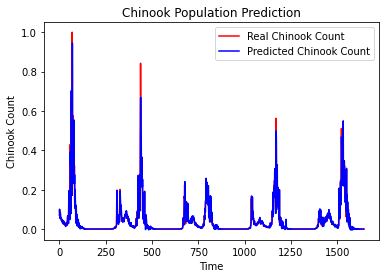

[4742]
0.09375577883252173


In [148]:
# norm_ytest = y_test
# norm_ytest = (king_test["king"] - np.min(king_test["king"])) / (np.max(king_test["king"]) - np.min(king_test["king"]))
salmon_count = temp(king_training, test_preds)
print(salmon_count)
plot_predictions(y_test, test_preds)
print(salmon_count[0])
print(y_test[0])

In [153]:
# accuracy = mean_absolute_error(y_test, np.round(salmon_count.reshape(salmon_count.shape[0])))
# MAE = mean_absolute_error(y_test, salmon_count)
# MSE = mean_squared_error(y_test, salmon_count)
# RMSE = math.sqrt(mean_squared_error(y_test, salmon_count))
MAE = mean_absolute_error(y_test, test_preds) # y_not_norm_test, salmon_count
MSE = mean_squared_error(y_test, test_preds)
RMSE = math.sqrt(mean_squared_error(y_test, test_preds))

In [154]:
print(salmon_count[70:80])
print(y_test[70:80])
print("MAE: ")
print(MAE)
print("MSE: ")
print(MSE)
print("RMSE: ")
print(RMSE)

[[63819]
 [26867]
 [15782]
 [29070]
 [20280]
 [31689]
 [23191]
 [18876]
 [21562]
 [37429]]
[0.54290205 0.36546878 0.44705048 0.32623436 0.57557172 0.34081243
 0.31535474 0.29680084 0.51525612 0.39712137]
MAE: 
0.014306660698552182
MSE: 
0.0019163266538541654
RMSE: 
0.043775868396345556


In [142]:
# find what the model does for the same y_val
print(np.where(y_test == 0))
print(np.where(salmon_count == 197))


(array([ 151,  153,  158,  161,  164,  165,  167,  168,  170,  171,  172,
        173,  174,  176,  178,  179,  181,  182,  183,  184,  185,  186,
        187,  188,  189,  190,  191,  192,  193,  194,  195,  196,  197,
        198,  199,  200,  201,  202,  203,  204,  205,  206,  207,  208,
        209,  210,  211,  212,  213,  214,  215,  216,  217,  218,  219,
        220,  221,  222,  223,  224,  225,  226,  228,  229,  230,  231,
        232,  233,  234,  235,  236,  237,  238,  239,  240,  241,  242,
        243,  244,  245,  246,  247,  248,  249,  250,  251,  253,  258,
        260,  261,  263,  264,  265,  266,  267,  268,  269,  270,  272,
        273,  274,  529,  540,  541,  543,  544,  545,  546,  547,  548,
        549,  550,  552,  553,  554,  555,  556,  558,  559,  560,  561,
        562,  563,  564,  565,  566,  567,  568,  569,  570,  571,  572,
        573,  574,  575,  576,  577,  578,  579,  580,  581,  582,  583,
        584,  585,  586,  587,  588,  589,  590,  

In [143]:
print(history.history.keys())

dict_keys(['loss'])


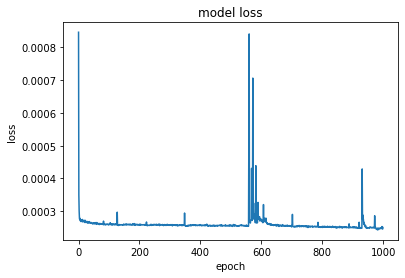

In [144]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
